In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import layers
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [18]:
df = pd.read_csv('fight_with_stats_precomp.csv')
df_fighters = pd.read_csv('fighter_total_stats.csv')

In [19]:
df = df[(df['fightNo_fighter']>=3) & (df['fightNo_opponent']>=3) & (df['Women_fight']==0)]

In [20]:
df = df.fillna(0)


In [21]:
df.head()

,EVENT,BOUT,FIGHTER,OPPONENT,METHOD,Win,Women_fight,ROUND,HEIGHT_diff,REACH_diff,...,BODY_landed_opponent,BODY_attemps_opponent,LEG_landed_opponent,LEG_attemps_opponent,DISTANCE_landed_opponent,DISTANCE_attemps_opponent,CLINCH_landed_opponent,CLINCH_attemps_opponent,GROUND_landed_opponent,GROUND_attemps_opponent
24,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Patrick Smith,Royce Gracie,KO/TKO - ground,0,0,1,1.0,0.0,...,0.0,0.0,3.0,5.0,5.0,10.0,0.0,0.0,0.0,0.0
25,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Royce Gracie,Patrick Smith,KO/TKO - ground,1,0,1,-1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,3.0,5.0
26,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Remco Pardoel,Royce Gracie,Submission,0,0,1,2.0,0.0,...,0.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,2.0
27,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Royce Gracie,Remco Pardoel,Submission,1,0,1,-2.0,0.0,...,1.0,2.0,0.0,1.0,0.0,3.0,1.0,1.0,3.0,5.0
50,UFC 4: Revenge of the Warriors,Royce Gracie vs. Dan Severn,Dan Severn,Royce Gracie,Submission,0,0,1,1.0,0.0,...,3.0,4.0,2.0,3.0,3.0,5.0,3.0,3.0,3.0,3.0


In [22]:
df.shape

(6817, 63)

In [23]:
df.columns.tolist()[19:62]

['KD_fighter',
 'SUB.ATT_fighter',
 'REV._fighter',
 'CTRL_fighter',
 'SIG.STR._landed_fighter',
 'SIG.STR._attemps_fighter',
 'TOTAL STR._landed_fighter',
 'TOTAL STR._attemps_fighter',
 'TD_landed_fighter',
 'TD_attemps_fighter',
 'HEAD_landed_fighter',
 'HEAD_attemps_fighter',
 'BODY_landed_fighter',
 'BODY_attemps_fighter',
 'LEG_landed_fighter',
 'LEG_attemps_fighter',
 'DISTANCE_landed_fighter',
 'DISTANCE_attemps_fighter',
 'CLINCH_landed_fighter',
 'CLINCH_attemps_fighter',
 'GROUND_landed_fighter',
 'GROUND_attemps_fighter',
 'KD_opponent',
 'SUB.ATT_opponent',
 'REV._opponent',
 'CTRL_opponent',
 'SIG.STR._landed_opponent',
 'SIG.STR._attemps_opponent',
 'TOTAL STR._landed_opponent',
 'TOTAL STR._attemps_opponent',
 'TD_landed_opponent',
 'TD_attemps_opponent',
 'HEAD_landed_opponent',
 'HEAD_attemps_opponent',
 'BODY_landed_opponent',
 'BODY_attemps_opponent',
 'LEG_landed_opponent',
 'LEG_attemps_opponent',
 'DISTANCE_landed_opponent',
 'DISTANCE_attemps_opponent',
 'CLINCH

In [24]:
df = df.merge(df[['EVENT', 'BOUT', 'FIGHTER']+df.columns.tolist()[18:62]] ,how='left', left_on=['EVENT', 'BOUT', 'OPPONENT'], right_on=['EVENT', 'BOUT', 'FIGHTER'], suffixes=('_f1', '_f2'))

In [25]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6817 entries, 0 to 6816
Data columns (total 108 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    EVENT                           6817 non-null   object 
 1    BOUT                            6817 non-null   object 
 2    FIGHTER_f1                      6817 non-null   object 
 3    OPPONENT                        6817 non-null   object 
 4    METHOD                          6817 non-null   object 
 5    Win                             6817 non-null   int64  
 6    Women_fight                     6817 non-null   int64  
 7    ROUND                           6817 non-null   int64  
 8    HEIGHT_diff                     6817 non-null   float64
 9    REACH_diff                      6817 non-null   float64
 10   AGE_diff                        6817 non-null   float64
 11   form_skore_fighter              6817 non-null   float64
 12   form_skore_opponen

In [26]:
cols_to_model = ['TotalTime_f1','TotalTime_f2','CTRL_fighter_f1','CTRL_fighter_f2','SIG.STR._landed_fighter_f1','SIG.STR._landed_fighter_f2','Win','form_skore_fighter', 'form_skore_opponent']

In [27]:
def prepare(df,cols_to_model):
    df_model = df[cols_to_model]
    df_model.loc[:,'pct_of_control_fighter1'] = df_model['CTRL_fighter_f1']/df_model['TotalTime_f1']
    df_model.loc[:,'pct_of_control_fighter2'] = df_model['CTRL_fighter_f2']/df_model['TotalTime_f2']
    df_model.loc[:,'strikes_fighter_f1'] = (df_model['SIG.STR._landed_fighter_f1']/df_model['TotalTime_f1'])*60
    df_model.loc[:,'strikes_fighter_f2'] = (df_model['SIG.STR._landed_fighter_f2']/df_model['TotalTime_f2'])*60
    df_model = df_model.drop(['TotalTime_f1','TotalTime_f2','CTRL_fighter_f1','CTRL_fighter_f2','SIG.STR._landed_fighter_f1','SIG.STR._landed_fighter_f2'],axis=1)
    df_model = df_model[['form_skore_fighter', 'pct_of_control_fighter1',
       'strikes_fighter_f1', 'form_skore_opponent','pct_of_control_fighter2','strikes_fighter_f2','Win']]
    df_model = df_model.fillna(0)
    return df_model

In [28]:
df_model= prepare(df, cols_to_model)

C:\Users\spravce\AppData\Local\Temp\ipykernel_24428\1830687690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,'pct_of_control_fighter1'] = df_model['CTRL_fighter_f1']/df_model['TotalTime_f1']
C:\Users\spravce\AppData\Local\Temp\ipykernel_24428\1830687690.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:,'pct_of_control_fighter2'] = df_model['CTRL_fighter_f2']/df_model['TotalTime_f2']
C:\Users\spravce\AppData\Local\Temp\ipykernel_24428\1830687690.py:5: SettingWithCopyWarn

In [29]:
#prepare(df_fighters,cols_to_model)

In [30]:
X

NameError: name 'X' is not defined

In [31]:
X=df_model.loc[:, ~df_model.columns.isin(['Win'])]
y=df_model['Win']

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 0)

In [34]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(multi_class='ovr', max_iter=50000)
logreg.fit(X_train,y_train)
predictions = logreg.predict(X_test)
acc = accuracy_score(y_test, predictions) 
f1 = f1_score(y_test, predictions,average='micro')
print(f1, acc)

0.5583577712609971 0.5583577712609971


In [35]:
class_neur = MLPClassifier(random_state=1, max_iter=100)

In [36]:
from keras.optimizers import SGD
opt = SGD(lr=0.001)

D:\anacinda\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [37]:
model = Sequential()
model.add(layers.Dense(8, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(4, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])  

In [38]:
history =model.fit(X_train, y_train, epochs=50, batch_size = 16, verbose=1,validation_data=(X_test, y_test))

Epoch 1/50
320/320 [==============================] - 1s 2ms/step - loss: 0.6995 - accuracy: 0.4879 - val_loss: 0.6922 - val_accuracy: 0.5296
Epoch 2/50
320/320 [==============================] - 0s 1ms/step - loss: 0.6902 - accuracy: 0.5252 - val_loss: 0.6881 - val_accuracy: 0.5572
Epoch 3/50
320/320 [==============================] - 0s 1ms/step - loss: 0.6851 - accuracy: 0.5561 - val_loss: 0.6862 - val_accuracy: 0.5578
Epoch 4/50
320/320 [==============================] - 0s 1ms/step - loss: 0.6828 - accuracy: 0.5493 - val_loss: 0.6856 - val_accuracy: 0.5584
Epoch 5/50
320/320 [==============================] - 0s 2ms/step - loss: 0.6813 - accuracy: 0.5624 - val_loss: 0.6860 - val_accuracy: 0.5554
Epoch 6/50
320/320 [==============================] - 1s 2ms/step - loss: 0.6807 - accuracy: 0.5640 - val_loss: 0.6854 - val_accuracy: 0.5554
Epoch 7/50
320/320 [==============================] - 0s 1ms/step - loss: 0.6796 - accuracy: 0.5673 - val_loss: 0.6853 - val_accuracy: 0.5525
Epoch 

In [39]:
test_loss, test_acc = model.evaluate(X_test, y_test)

54/54 [==============================] - 0s 943us/step - loss: 0.6859 - accuracy: 0.5519


54/54 [==============================] - 0s 717us/step


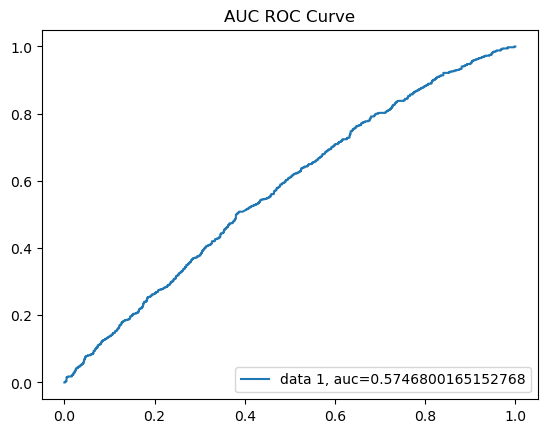

In [40]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_proba =model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("AUC ROC Curve")
plt.show()

In [41]:
fighter1 = "Dustin Poirier"
fighter2 = "Conor McGregor"

In [42]:
df_fighters.loc[:,'pct_of_control_fighter'] = df_fighters['CTRL_fighter']/df_fighters['TotalTime']
df_fighters.loc[:,'strikes_fighter_f'] = (df_fighters['SIG.STR._landed_fighter']/df_fighters['TotalTime'])*60


In [57]:
df_fighters[['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']] = scaler.fit_transform(df_fighters[['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']])

In [58]:
f1 = df_fighters.loc[df_fighters["FIGHTER"]==fighter1 ,['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']].values.flatten().tolist()

In [59]:
f2 = df_fighters.loc[df_fighters["FIGHTER"]==fighter2 ,['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']].values.flatten().tolist()

In [60]:
f1+f2

[1.5395714026745009,
 0.22917625299622157,
 1.6618094549943803,
 -0.45686035044738443,
 -0.5655206746811349,
 1.4218252543277097]

In [61]:
predikce = model.predict([f1+f2])
predikce[0][0]

1/1 [==============================] - 0s 33ms/step


0.64517826

In [62]:
print(f"{fighter1}: {round(predikce[0][0]*100,2)}%  vs {fighter2}: {round((1-predikce[0][0])*100,2)}")

Dustin Poirier: 64.52%  vs Conor McGregor: 35.48


In [66]:
'McGr' in df_fighters['FIGHTER'].tolist()

False